## Soccer Networks

**Yuval Berman**

Making passing networks out of the events logs stream.

(ready to execute for all of Spain's games - just add a command which saves these to a new dataframe and then analyse it).

In [2]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.cm as mplcm
import matplotlib.colors as colors

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3tq2rcmx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

#allDone()

In [12]:
# Navigate to the relevant directory
os.chdir('/group/interns2021031/yberman/')
os.listdir()

['slurm-223253.out',
 'slurm-225840.out',
 'other_data',
 'filetransfer',
 '.singularity',
 'jupyter-gpu-notebook-one-singularity.slm',
 'slurm-225156.out',
 'slurm-225850.out',
 'mpi_workshop',
 'cleaned_events_data',
 'first_topaz_run.slm',
 'test_mnist.py',
 'slurm-223256.out']

In [14]:
# Read in the players (not necessary for global entropy, but helps if wanting to find individual node
# entropy or visualise the passing network)
players = pd.read_json('other_data/players.json')
players = players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [16]:
cleaned_events = os.listdir('cleaned_events_data/')

In [36]:
def initial_df_processing(name):
    
    df = pd.read_json('cleaned_events_data/'+name)
    
    # Merge the two databases together
    df = df.merge(players, how = 'left', on = 'playerId')
    
    # Let's clean it up a bit and get rid of some unnecessary info so we have just what we need
    df.drop(['passportArea', 'weight', 'firstName','middleName','lastName','currentTeamId',
         'birthDate','height','role','foot','currentNationalTeamId','birthArea','subEventId',
         'id','xStart', 'xEnd', 'yStart', 'yEnd', 'attackMetres'],inplace = True, axis = 1)
    
    return df

In [37]:
def get_game(df, matchId):
    # Finds the match we're after.
    df = df.loc[df['matchId'] == matchId]
    return df

In [38]:
def continuous_time(df):
    # Converts to a continuous 90 min (ie 90*60 = 5400 second) game
    firsthalf = df.loc[df['matchPeriod'] == '1H']
    first_half_length = list(firsthalf['eventSec'])[-1]
    df.loc[ df.matchPeriod == '2H' , 'eventSec'] += first_half_length
    return df

In [39]:
def event_handling(df):
    # Cleans things up based on our interpretation of the events and how they relate to passes. Note the meaning of
    # the events:
    # 1 - duels (this is a hard one to define as it means many different things)
    # 2 - fouls
    # 3 - free kicks / corners (hence we add a node so that it picks these up as the first play in the chain)
    # 4 - keeper leaving their line
    # 7 - Touch, acceletation or clearance (also vague- get rid of touch/acc but keep clearance if its accurate)
    # 8 - Pass - simple/smart, cross (main data we're after for this)
    # 9 - Reflexes / save (however if tagged as inaccurate it means there was a goal)
    # 10- Shot (add a shot node)
    
    df = df.loc[ df['eventId'] != 9]
    df = df.loc[ df['eventId'] != 1]
    df = df.loc[ df['eventId'] != 2]
    df = df.loc[ df['eventId'] != 4]
    df = df.loc[ df['eventId'] != 7]
    df = df.loc[ df['subEventName'] != 'Touch']
    df = df.loc[ df['subEventName'] != 'Acceleration']
    df = df.loc[ (df['subEventName'] != 'Clearance') | (df['Result'] == 'Inaccurate')]
    df = df.drop(df[(df.subEventName == 'Clearance') & (df.Result =='Inaccurate')].index)

    # Create some new columns to see where passes ended up etc
    df["next_event"] = df['eventId'].shift(-1)
    df["next_teamId"] = df["teamId"].shift(-1)
    df["next_player"] = df["shortName"].shift(-1)
    df.loc[ df["next_event"] == 3, 'next_player'] = 0.5
    df.loc[ df["eventId"] == 10, 'next_player'] = 0
    
    return df

In [40]:
def passeslist(df, teamIds):
    
    # Create a Passes column which only has successive events between the same team 
    df = df.drop( df[(df.teamId != df.next_teamId) & (df.next_player != 0)].index)
    df['Passes'] = list(zip(df['shortName'], df['next_player']))
    
    # Get a passes list for each team
    passes = []
    for team in teamIds:    
        temp = df.loc[df['teamId'] == team]
        passes.append(list(temp['Passes']))

    return passes[0], passes[1]

In [41]:
def weighted_passes(passes):
    # Builds a network for the team based on the passes as edges
    n = nx.DiGraph()
    for (i,j) in passes:
        if n.has_edge(i,j):
            n[i][j]['weight'] += 1
        else:
            n.add_edge(i,j, weight = 1)
    
    # Remove node 0.5 as only used to signify start of plays from free kicks / corners
    if 0.5 in n.nodes():
        n.remove_node(0.5)
        
    return n

In [42]:
# Defines a function to calculate the entropy of each node from the transition matrix.
def entropy(row):
    enode = 0
    for item in row:
        if item > 0:
            enode -= item * math.log10(item) # Entropy formula for each node.
    return enode

In [43]:
def find_entropy(net):
    # This function attempts to calculate a team's entropy- i.e. their unpredictability.
    
    n = net
    n = nx.relabel_nodes(n, {0:'ZZ'})
    
    # A stochastic graph gives the probabilities of connections between certain platers       
    prob = nx.stochastic_graph(n)
    
    # Allows us to sort nodes alphabetically so that we can easily remove shot node later
    playerlist = sorted(list(n.nodes()))
    
    # Generates transition matrix
    probmat = nx.adjacency_matrix(prob, nodelist = playerlist)
    probmat = probmat.todense()
    matrix = np.array(probmat) # turns it into numpy array so that we can operate on it

    entnode =  np.apply_along_axis( entropy, axis=1, arr = matrix ) # calculates entropy for each node

    entnode = entnode[:-1] # Gets rid of entropy of shot node

    entrop = sum(entnode)/len(n.nodes()) # Gets the average
        
    return entrop

In [44]:
def sliding_window_entropy(df,teams):
    # This function iterates sliding 10 minute windows, moving forward by 30 seconds each time and calculate a 
    # team's entropy during that 30 second window
    entropy1 = []
    entropy2 = []
    total1 = []
    total2 = []
    
    # Iterate sliding windows over the game length
    for i in range(0,int(list(df['eventSec'])[-1])-600,30):
        
        # locate the window in the database
        temp_df = df.loc[df['eventSec'] < i + 600]
        temp_df = temp_df.loc[temp_df['eventSec'] > i]
        
        # Get pass list, create a network, and find that network's entropy
        pass1, pass2 = passeslist(temp_df, teams)

        net1 = weighted_passes(pass1)
        net2 = weighted_passes(pass2)

        # The team's total amount of passes during that 10 minute window 
        tot1 = 0
        tot2 = 0
        for item in list(net1.edges(data=True)):
            tot1 += item[2]['weight']
        for item in list(net2.edges(data=True)):
            tot2 += item[2]['weight']
        
        if tot1 > 0:
            ent1 = find_entropy(net1)
        else:
            ent1 = 0
            
        if tot2 > 0:
            ent2 = find_entropy(net2)
        else:
            ent2 = 0
        
        # Make lists and append entropy for that window for each team
        entropy1.append(ent1)
        entropy2.append(ent2)

    return entropy1, entropy2

In [45]:
def add_ons(lis, long):
    # Add NaNs if the game finished before the max time (see below)
    
    while len(lis) < 2*long - 10:
        lis.append(np.nan)
        
    return lis

In [46]:
def game_iterator(master_df):
    
    #Shows what the longest half is and converts to longest possible match
    longest_game = math.ceil(max(master_df['eventSec'])*2 / 60)
    
    matches = list(set(master_df['matchId']))
    
    mins = []
    for i in range(10,170):
        mins.append(i/2)

    results = []
    
    for m in range(len(matches)):
        print(m)
        match = matches[m]
        
        df = get_game(master_df,match)
        df = continuous_time(df)
        
        df = event_handling(df)
        
        teams = list(set(df['teamId']))
        
        entropy1, entropy2 = sliding_window_entropy(df, teams)
        
        #final1 = add_ons(entropy1, longest_game)
        #final2 = add_ons(entropy2, longest_game)
        final1 = entropy1[:160]
        final2 = entropy2[:160]
        
        results.append([teams[0], teams[1], match] + final1)
        results.append([teams[1], teams[0], match] + final2)        
    
    entropies = pd.DataFrame(results, columns = ['teamId','Opponent','matchId'] + mins )
    
    return entropies     

In [47]:
def plotter(df, name):
    teams = list(set(df['teamId']))

    mins = []
    for i in range(10,170):
        mins.append(i/2)

    NUM_COLORS = 20

    cm = plt.get_cmap('tab20')
    fig = plt.figure(figsize = (18,12))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    plt.title('Entropy over the course of a game for teams in the ' + name[15:19] +
              ' league averaged out over their whole season')
    plt.xlabel('Minute of the game')
    plt.ylabel('Team entropy')
    for t in teams:
        se = df.loc[df['teamId'] == t]
        teamname = list(set(se['name']))[0]

        teams_ent = list(se.mean())[3:]

        ax.plot(mins, teams_ent, label = teamname)
    plt.legend()
    plt.show()

In [48]:
# Read in teams df
Teams = pd.read_json('other_data/teams.json')
Teams = Teams.rename(columns = {'wyId': 'teamId'})

In [49]:
os.listdir()

['slurm-223253.out',
 'slurm-225840.out',
 'other_data',
 'filetransfer',
 '.singularity',
 'jupyter-gpu-notebook-one-singularity.slm',
 'slurm-225156.out',
 'slurm-225850.out',
 'mpi_workshop',
 'cleaned_events_data',
 'entropies_df',
 'first_topaz_run.slm',
 'test_mnist.py',
 'slurm-223256.out']

In [50]:
def main(name):
    
    df = initial_df_processing(name)
    
    ent_df = game_iterator(df)
    
    ent_df = ent_df.merge(Teams, how = 'left', on = 'teamId')
    
    ent_df.to_json('entropies_df/entropies_'+name[14:])
    
    plotter(ent_df, name)

cleaned_events_World_Cup.json
0


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


/tmp/ipykernel_31/2207973671.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  teams_ent = list(se.mean())[3:]


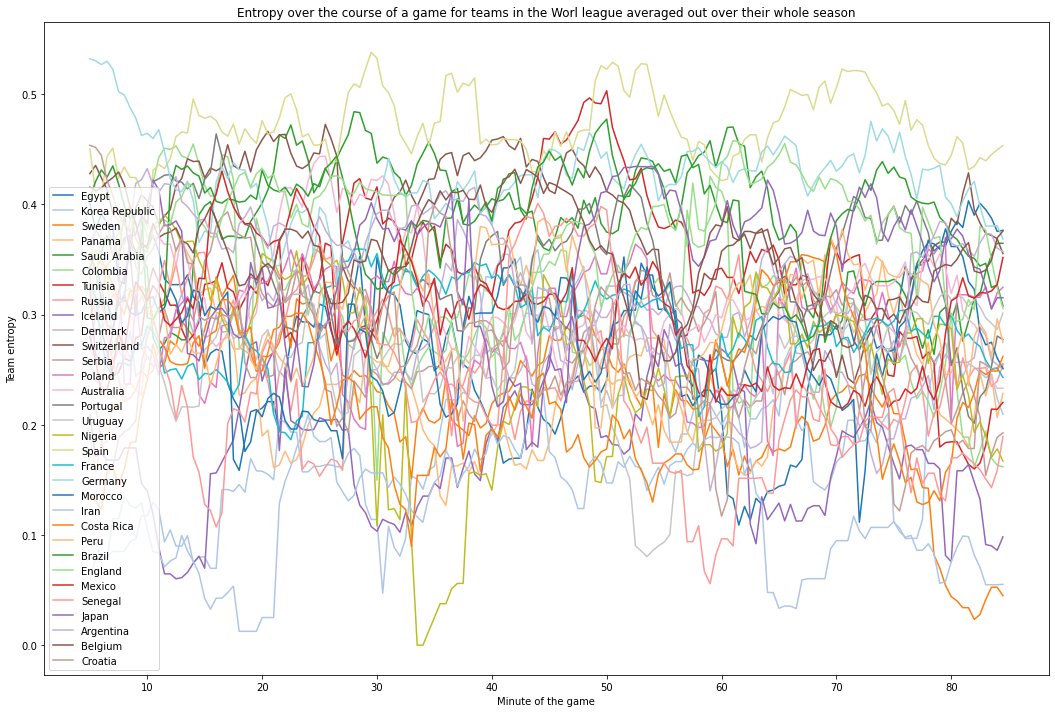

cleaned_events_England.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
27

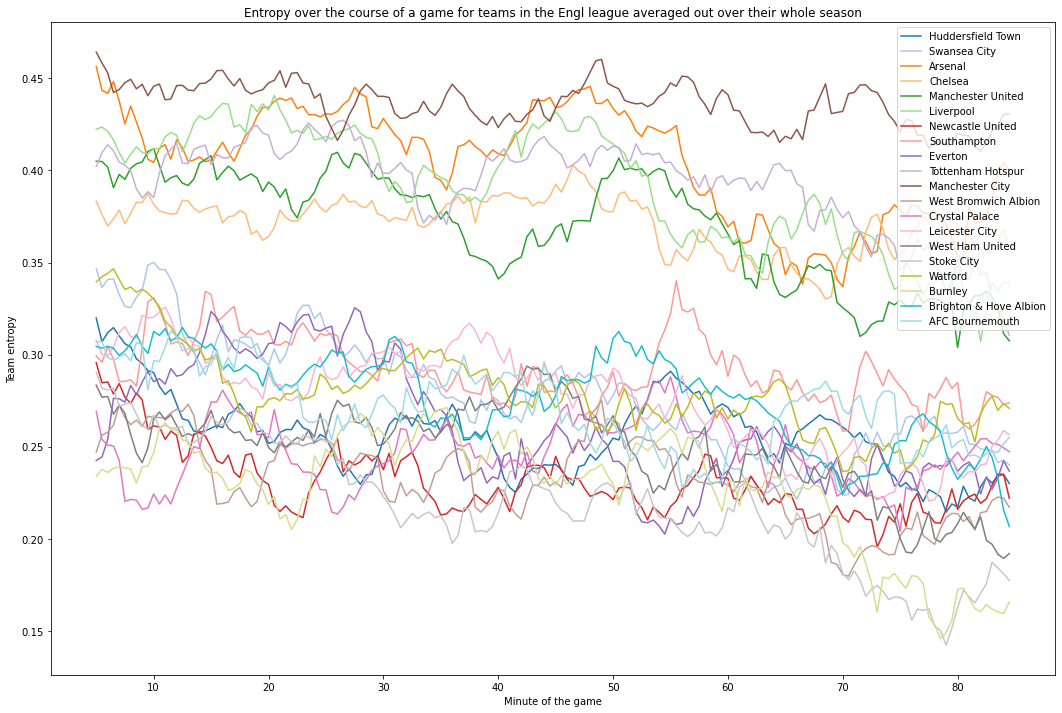

cleaned_events_Spain.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


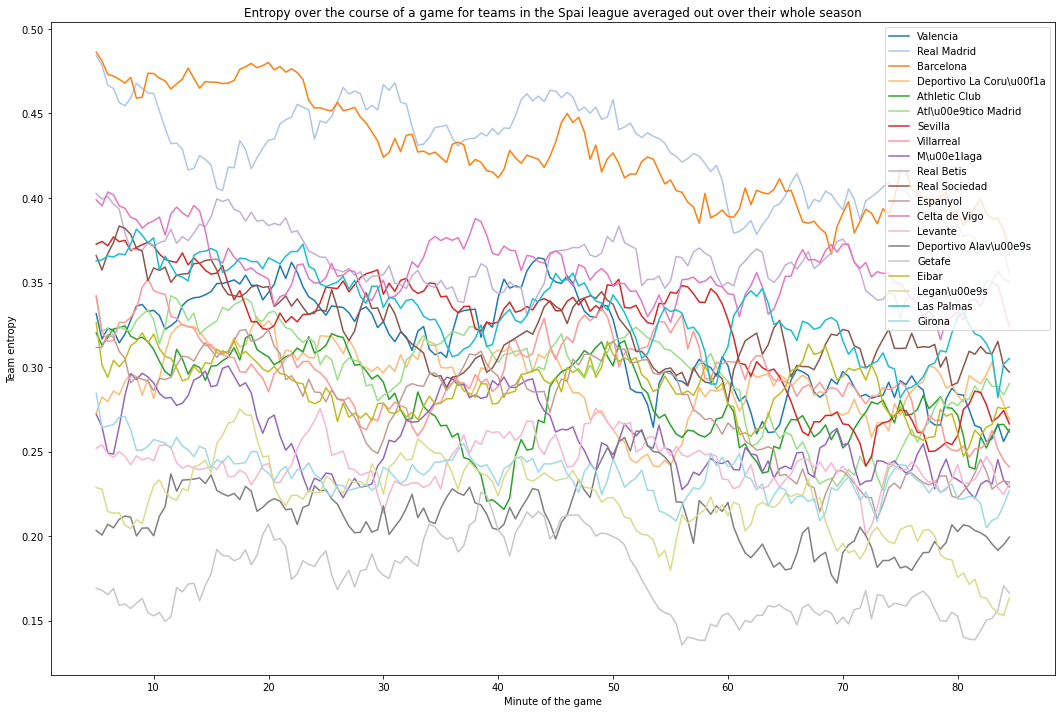

cleaned_events_Germany.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
27

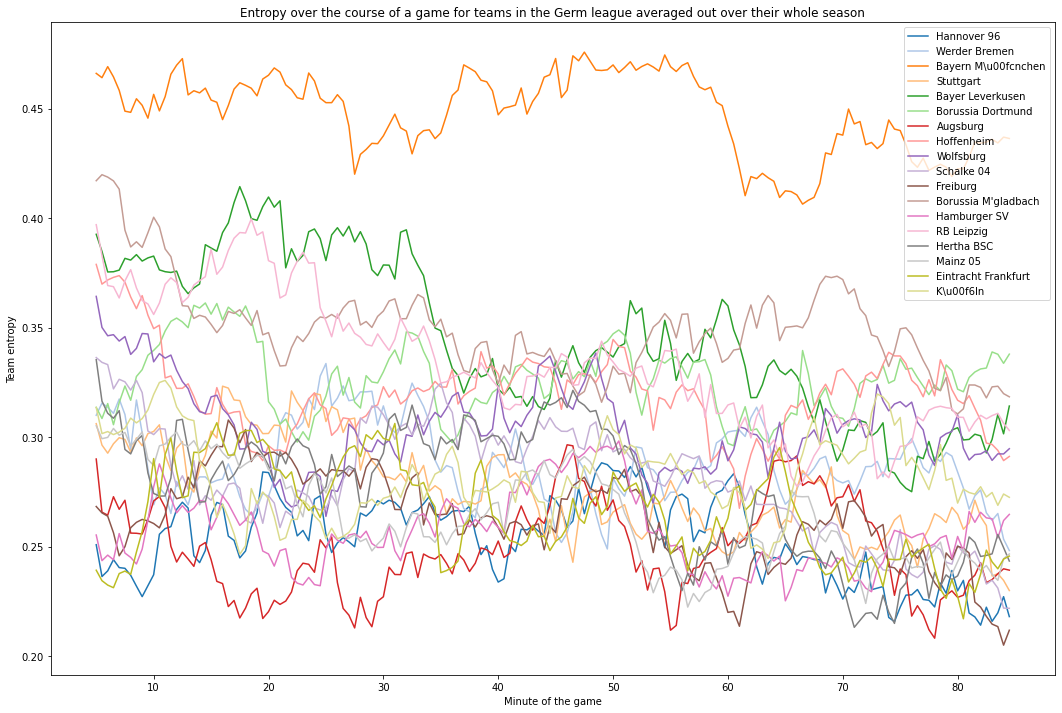

cleaned_events_European_Championship.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


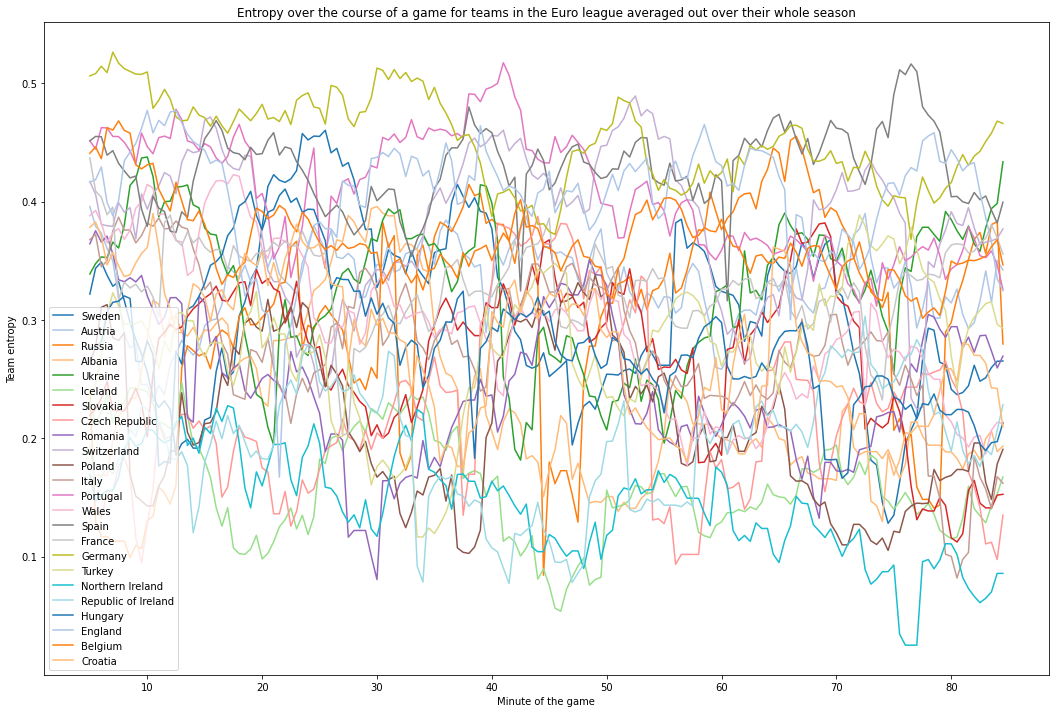

cleaned_events_France.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270

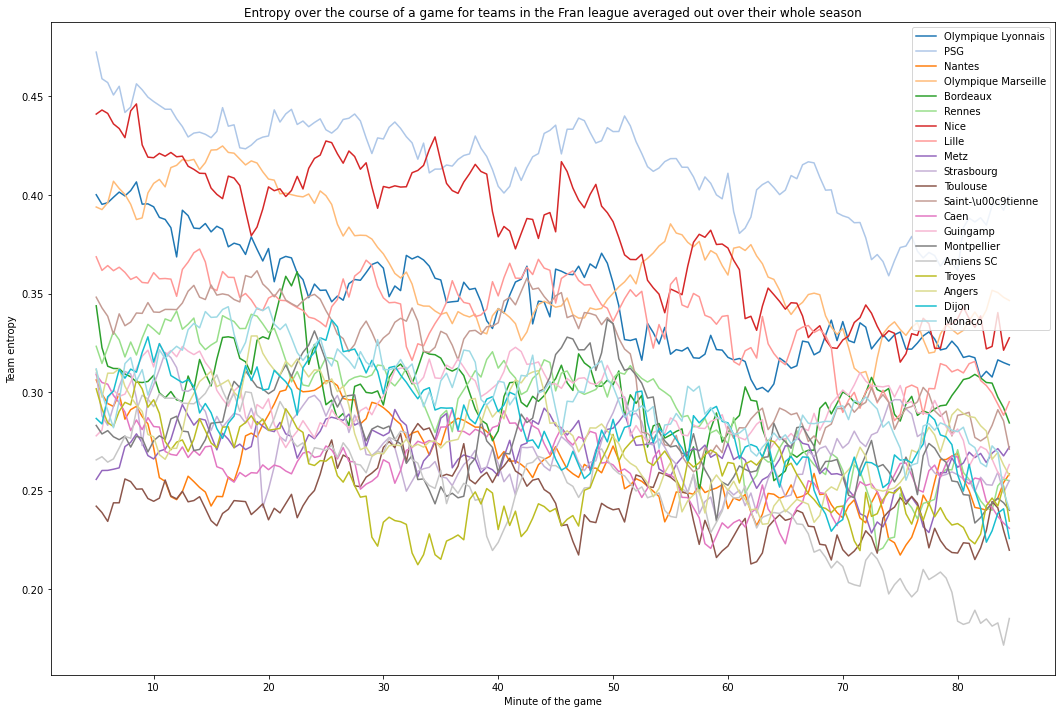

cleaned_events_Italy.json
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


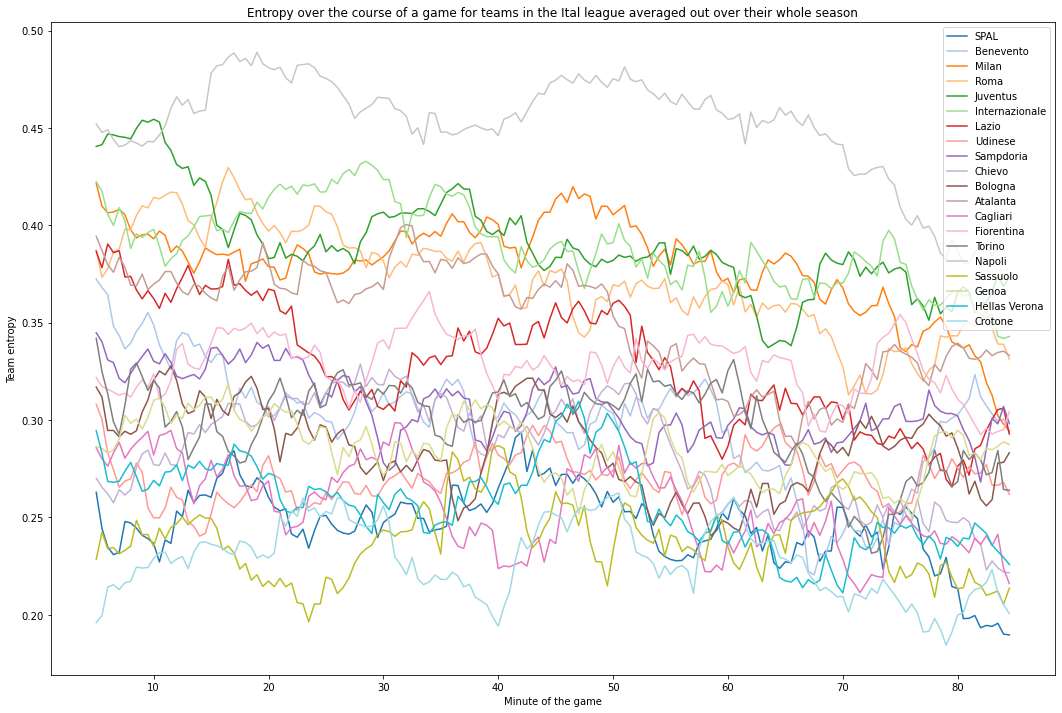

In [51]:
for name in cleaned_events:
    
    print(name)
    main(name)

In [ ]:
def onegame_entropy(df,home,away):
    
    

In [9]:
# 3-0 el classico - 2565711
# 2-2 el classico - 2565907
df = get_game(df,2565907)
df = df.loc[df['matchPeriod'] == '2H']

In [10]:
df.loc[df['matchPeriod'] == '2H']

eventId            subEventName  playerId  matchId  teamId  \
502433        8             Simple pass      7972  2565907     676   
502434        8             Simple pass      3346  2565907     676   
502435        8             Simple pass    222770  2565907     676   
502436        8             Simple pass      3341  2565907     676   
502437        8             Simple pass     15008  2565907     676   
...         ...                     ...       ...      ...     ...   
503213        7                   Touch      8278  2565907     675   
503214        7               Clearance    222770  2565907     676   
503215        3                  Corner      4498  2565907     675   
503216        1  Ground loose ball duel      3306  2565907     675   
503217        1  Ground loose ball duel      3476  2565907     676   

       matchPeriod     eventSec      Result subEventDescription  \
502433          2H     2.269118    Accurate        generic play   
502434          2H     5.145951    Accurate        generic play   
502435          2H     9.471353    Accurate        generic play   
502436          2H    12.405746    Accurate        generic play   
502437          2H    16.627808    Accurate        generic play   
...            ...          ...         ...                 ...   
503213          2H  2968.286164                     opportunity   
503214          2H  2968.944215  Inaccurate        interception   
503215          2H  2982.539784    Accurate                high   
503216          2H  2983.141976  Inaccurate                lost   
503217          2H  2983.907855    Accurate                 won   

                 shortName  
502433      L. Su\u00e1rez  
502434     Sergio Busquets  
502435  N\u00e9lson Semedo  
502436          Piqu\u00e9  
502437       M. ter Stegen  
...                    ...  
503213             G. Bale  
503214  N\u00e9lson Semedo  
503215  Lucas V\u00e1zquez  
503216        Sergio Ramos  
503217     I. Rakiti\u0107  

[785 rows x 10 columns]

In [11]:
df = df.loc[ df['eventId'] != 9]
df = df.loc[ df['eventId'] != 1]
df = df.loc[ df['eventId'] != 2]
df = df.loc[ df['eventId'] != 4]
df = df.loc[ df['eventId'] != 7]
df = df.loc[ df['subEventName'] != 'Touch']
df = df.loc[ df['subEventName'] != 'Acceleration']
df = df.loc[ (df['subEventName'] != 'Clearance') | (df['Result'] == 'Inaccurate')]
df = df.drop(df[(df.subEventName == 'Clearance') & (df.Result =='Inaccurate')].index)


df["next_event"] = df['eventId'].shift(-1)
df["next_teamId"] = df["teamId"].shift(-1)
df["next_player"] = df["shortName"].shift(-1)
df.loc[ df["next_event"] == 3, 'next_player'] = 0.5
df.loc[ df["eventId"] == 10, 'next_player'] = 0

In [12]:
df.drop(['next_event'],inplace = True, axis = 1)
df.head(5)

eventId subEventName  playerId  matchId  teamId matchPeriod  \
502433        8  Simple pass      7972  2565907     676          2H   
502434        8  Simple pass      3346  2565907     676          2H   
502435        8  Simple pass    222770  2565907     676          2H   
502436        8  Simple pass      3341  2565907     676          2H   
502437        8  Simple pass     15008  2565907     676          2H   

         eventSec    Result subEventDescription           shortName  \
502433   2.269118  Accurate        generic play      L. Su\u00e1rez   
502434   5.145951  Accurate        generic play     Sergio Busquets   
502435   9.471353  Accurate        generic play  N\u00e9lson Semedo   
502436  12.405746  Accurate        generic play          Piqu\u00e9   
502437  16.627808  Accurate        generic play       M. ter Stegen   

        next_teamId         next_player  
502433        676.0     Sergio Busquets  
502434        676.0  N\u00e9lson Semedo  
502435        676.0          Piqu\u00e9  
502436        676.0       M. ter Stegen  
502437        676.0             Iniesta

In [132]:
pass1, pass2 = passeslist(df, [675, 676])

In [133]:
net1 = weighted_passes(pass1)
net2 = weighted_passes(pass2)

In [134]:
len(net1.nodes())

12

In [17]:
list(df['eventSec'])[-1]//30

99.0

In [180]:
pass1, pass2 = passeslist(temporary, [675, 676])

In [196]:
pass1
net1 = weighted_passes(pass1)
n = net1
n = nx.relabel_nodes(n, {0:'ZZ'})
prob = nx.stochastic_graph(n)
playerlist = sorted(list(n.nodes()))
probmat = nx.adjacency_matrix(prob, nodelist = playerlist)
probmat = probmat.todense()
matrix = np.array(probmat)
entnode =  np.apply_along_axis( entropy, axis=1, arr = matrix ) # calculates entropy for each node
entnode

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
tot = 0
for item in list(net1.edges(data=True)):
    tot += item[2]['weight']
tot

2

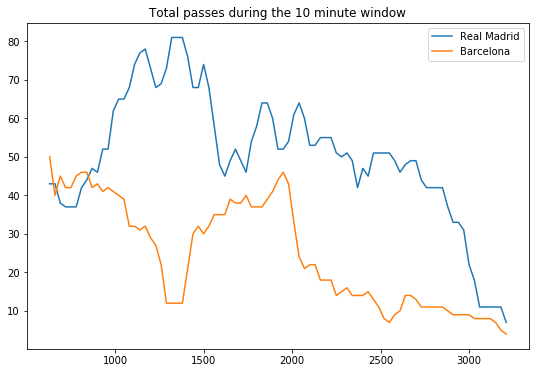

In [20]:
plt.figure(figsize = (9,6))
plt.title('Total passes during the 10 minute window')
plt.plot(list(zip(*total1))[0],list(zip(*total1))[1], label = 'Real Madrid')
plt.plot(list(zip(*total2))[0],list(zip(*total2))[1], label = 'Barcelona')
plt.legend()

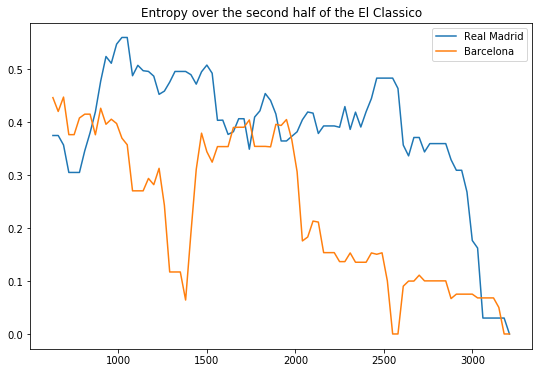

In [22]:
plt.figure(figsize = (9,6))
plt.title('Entropy over the second half of the El Classico')
plt.plot(list(zip(*entropy1))[0],list(zip(*entropy1))[1], label = 'Real Madrid')
plt.plot(list(zip(*entropy2))[0],list(zip(*entropy2))[1], label = 'Barcelona')
plt.legend()

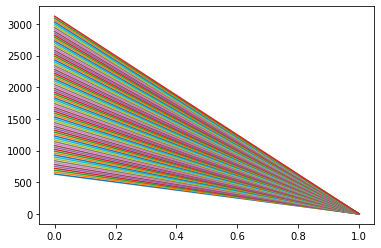

In [74]:
plt.plot(list(zip(*entropy1)))

In [ ]:
def ten_min_n(passes, t):
    
    # Now is the time to generate a 10 minute network.
    
    tenmin_passes = []
    
    for p in passes:
        if (t < p[2]) & (p[2] <= t+600): # Only take passes in our 10 minute window
            tenmin_passes.append(p)
    
    # Generates a passing network and a shot network, so that each one can be called for 
    # calculation of its relevant metric.
    tenshotlist = get_shot_net(tenmin_passes)
    shotnet = generate_graph(tenshotlist)
    
    # Calculating some metrics by calling other functions and feeding in the appropriate network.
    p_used = len(list(passnet.nodes()))
    out_deg, in_deg, out_str, in_str = get_deg(shotnet)
    bet, nonzero = get_bet(shotnet)
    close = get_clo(passnet)
    clu = get_clu(passnet)
    dispeff = get_disp_eff(tenmin_passes)
    shoteff = get_shot_eff(tenmin_passes)
    passrate, passrateshots = get_passrate(tenmin_passes)
    evecstd = get_evec_std(passnet)
    chainlen = get_chainlen(tenmin_passes)
    ent = get_entropy(shotnet)
    
    # Returns directly to main(). We return the original list of passes back so that we don't make any changes to it 
    # for next time it is input.
    return score, neg, p_used, out_deg, in_deg, out_str, in_str, bet, nonzero, close, clu, dispeff, shoteff, passrate, passrateshots, evecs

In [29]:
print(find_entropy(net1), find_entropy(net2)) 

0.8072192066874979 0.7620813680864298


In [29]:
print(nx.degree_centrality(net1))
print(nx.betweenness_centrality(net2))

{'K. Benzema': 0.6428571428571428, 'M. Kova\\u010di\\u0107': 0.7857142857142857, 'R. Varane': 1.357142857142857, 'L. Modri\\u0107': 1.6428571428571428, 'Sergio Ramos': 1.2857142857142856, 'Marcelo': 1.2857142857142856, 'Cristiano Ronaldo': 0.7142857142857142, 'Daniel Carvajal': 0.5714285714285714, 0: 0.2857142857142857, 'T. Kroos': 1.2857142857142856, 'K. Navas': 0.42857142857142855, 'Casemiro': 0.8571428571428571, 'Nacho': 0.8571428571428571, 'G. Bale': 0.7857142857142857, 'Marco Asensio': 0.6428571428571428}
{'Sergi Roberto': 0.05113160648874935, 'Paulinho': 0.017745944531658817, 'Iniesta': 0.008313710099424386, 'Sergio Busquets': 0.03580586080586081, 'L. Su\\u00e1rez': 0.015247252747252749, 'Piqu\\u00e9': 0.04984955520669807, 'I. Rakiti\\u0107': 0.05247252747252748, 'Jordi Alba': 0.02473835688121402, 'T. Vermaelen': 0.035119047619047626, 'L. Messi': 0.1812140240711669, 0: 0.0, 'M. ter Stegen': 0.0168694400837258, 'N\\u00e9lson Semedo': 0.013867085295656724, 'Andr\\u00e9 Gomes': 0.00

In [25]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

eventId     subEventName  playerId  matchId  teamId     eventSec  \
227720        8      Simple pass      3321  2565711     675     1.681818   
227721        8      Simple pass     69404  2565711     675     3.532153   
227722        8      Simple pass      3309  2565711     675     6.140737   
227723        8      Simple pass      8287  2565711     675     8.707625   
227724        8      Simple pass      3309  2565711     675    11.682937   
227725        8      Simple pass      3306  2565711     675    14.106997   
227726        8      Simple pass      3310  2565711     675    16.828160   
227727        8      Simple pass      3322  2565711     675    17.995597   
227728        8      Simple pass      3310  2565711     675    20.502604   
227729        8        High pass      3309  2565711     675    23.923104   
227730        8        Head pass      3347  2565711     676    24.959514   
227731        8      Simple pass     40550  2565711     676    29.741920   
227733        8      Simple pass      3347  2565711     676    31.267088   
227734        8      Simple pass     40550  2565711     676    32.232133   
227737        8      Simple pass      3347  2565711     676    37.970934   
227740        8      Simple pass     69404  2565711     675    40.478125   
227741        8      Simple pass      8287  2565711     675    43.196647   
227742        8      Simple pass      3321  2565711     675    45.463679   
227743        8      Simple pass      4501  2565711     675    47.716525   
227744        8      Simple pass      8287  2565711     675    49.935400   
227745        8      Simple pass      4501  2565711     675    56.090946   
227746        8        High pass      8287  2565711     675    61.965542   
227747        8        High pass      3310  2565711     675    65.444545   
227750       10             Shot      3322  2565711     675    74.970465   
227753        8      Simple pass     14723  2565711     675   110.145786   
227756        8      Simple pass     14723  2565711     675   138.855238   
227757        8      Simple pass      3915  2565711     675   141.892112   
227758        8      Simple pass      3353  2565711     676   143.416116   
227759        8        High pass      3346  2565711     676   146.102628   
227760        8      Simple pass      7972  2565711     676   149.385608   
227761        8      Simple pass      3353  2565711     676   154.278327   
227765        8        Hand pass      3915  2565711     675   165.471993   
227766        8      Simple pass      3309  2565711     675   170.320902   
227769        8      Simple pass      3321  2565711     675   173.685766   
227770        8      Simple pass      4501  2565711     675   175.920732   
227771        8      Simple pass      3321  2565711     675   177.917591   
227772        8      Simple pass      4501  2565711     675   178.934514   
227773        8      Simple pass      8287  2565711     675   181.828859   
227778        8      Simple pass     40756  2565711     675   186.765664   
227779        8      Simple pass      3306  2565711     675   188.418481   
227780        8      Simple pass     40550  2565711     676   196.033077   
227781        8      Simple pass      3347  2565711     676   199.643598   
227782        8      Simple pass      3341  2565711     676   208.220348   
227783        8      Simple pass      3476  2565711     676   209.078720   
227784        8      Simple pass      3347  2565711     676   209.297622   
227785        8      Simple pass     40550  2565711     676   211.326586   
227786        8      Simple pass      3347  2565711     676   212.987452   
227787        8      Simple pass      3341  2565711     676   218.270666   
227789        8      Simple pass      3476  2565711     676   221.872421   
227790        8      Simple pass      3346  2565711     676   224.346160   
227791        8      Simple pass      3353  2565711     676   226.928064   
227792        8      Simple pass      3269  2565711     

In [260]:
fin = list(df.index)

In [261]:
time = list(df['eventSec'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


IndexError: list index out of range

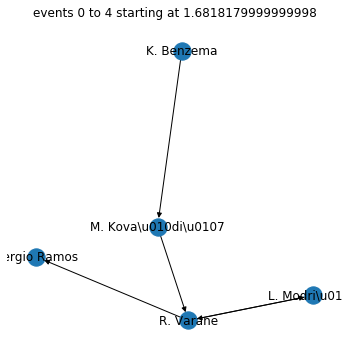

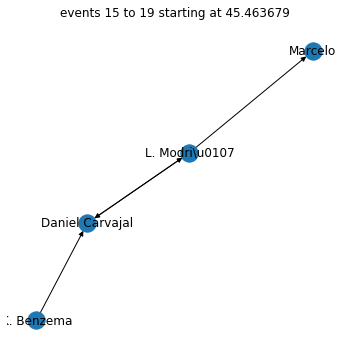

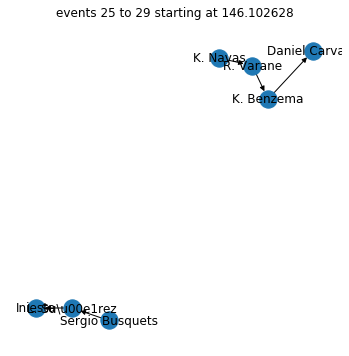

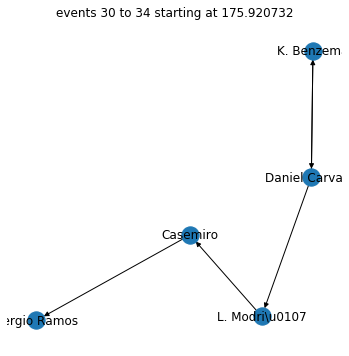

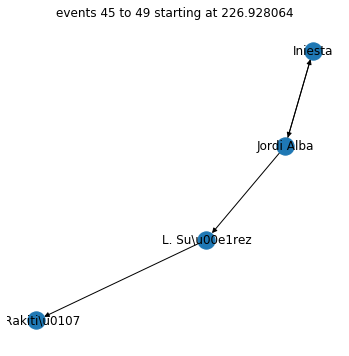

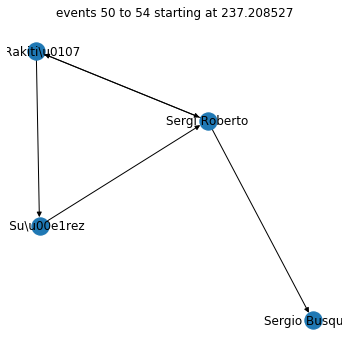

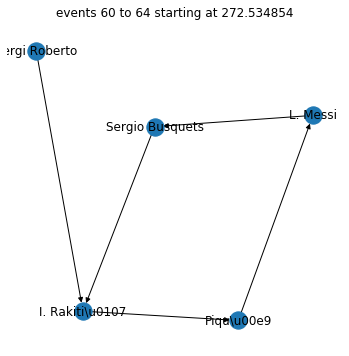

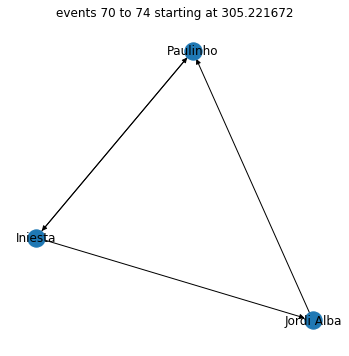

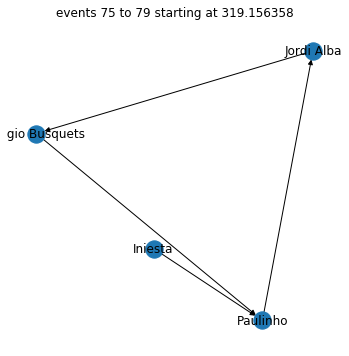

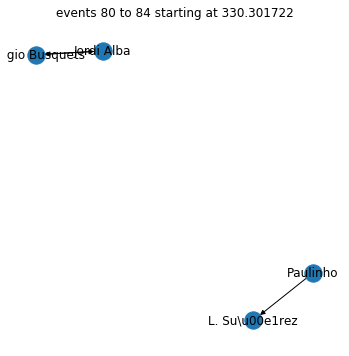

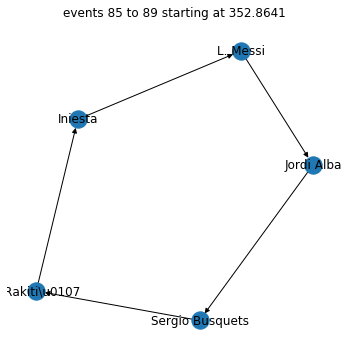

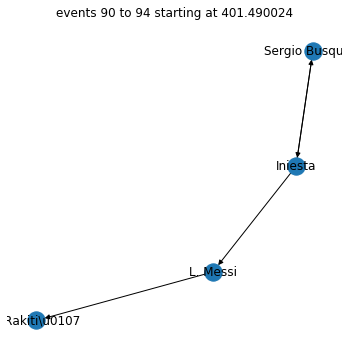

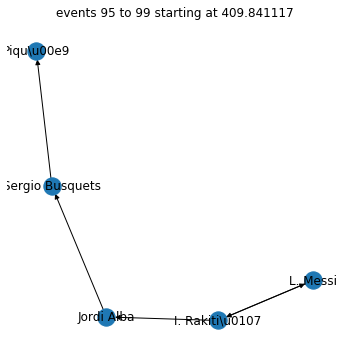

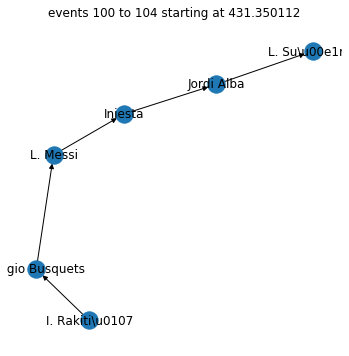

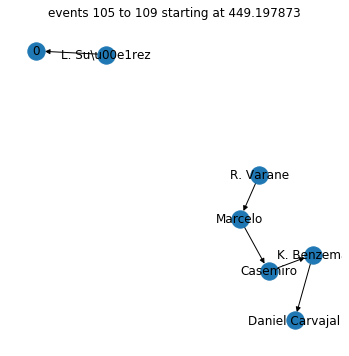

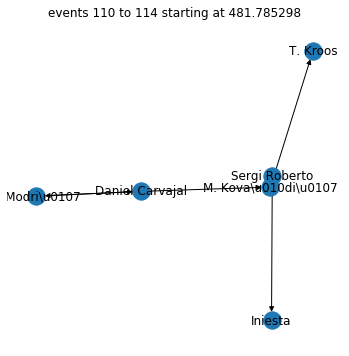

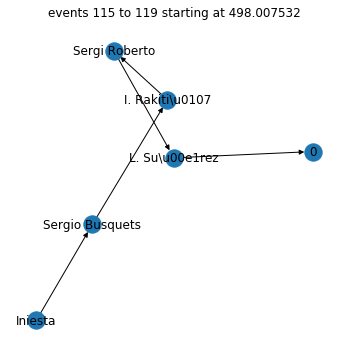

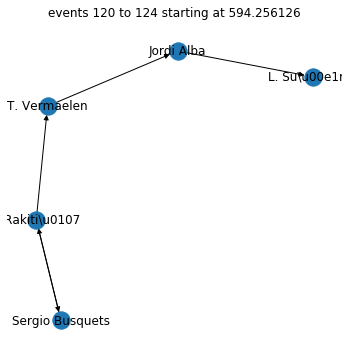

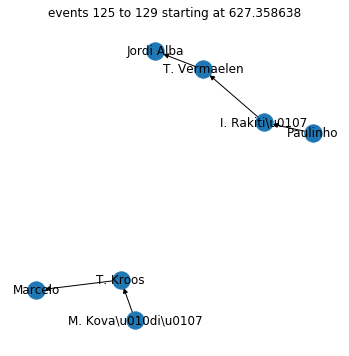

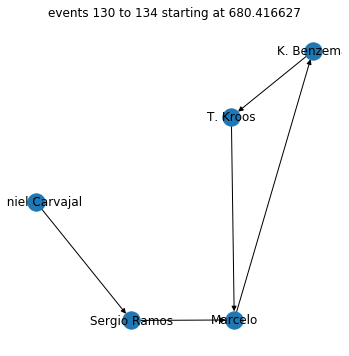

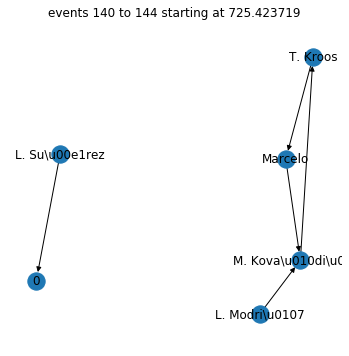

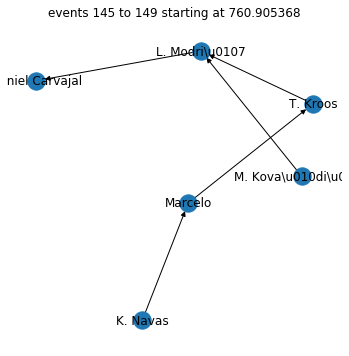

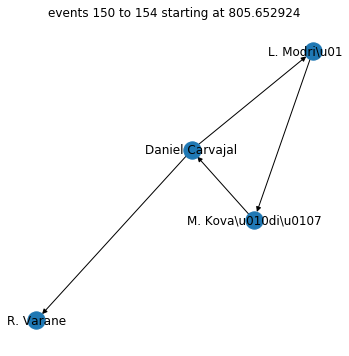

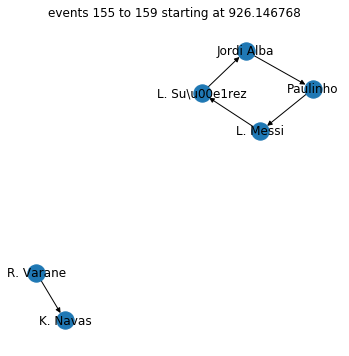

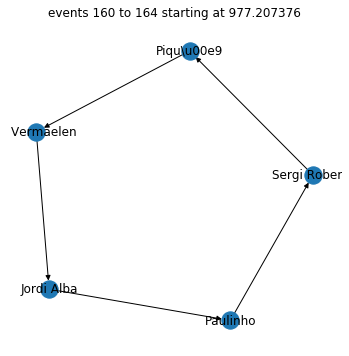

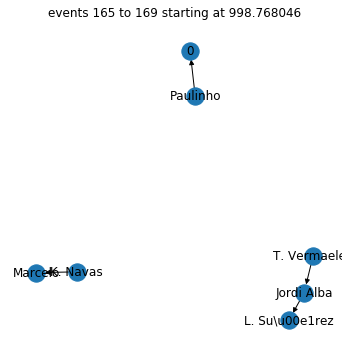

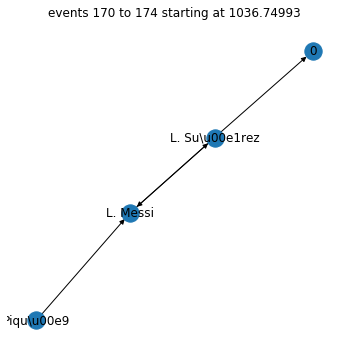

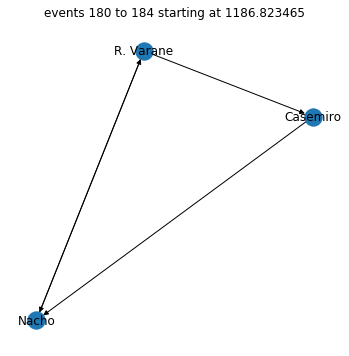

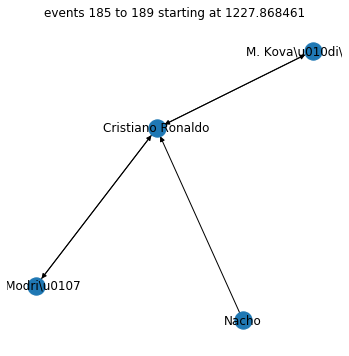

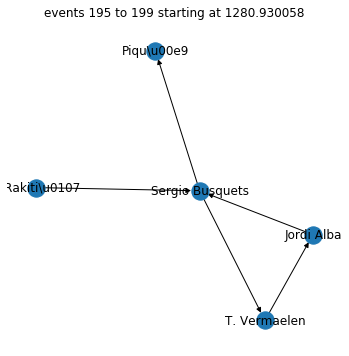

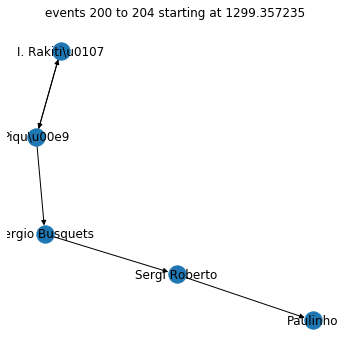

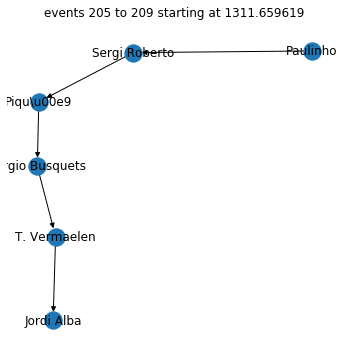

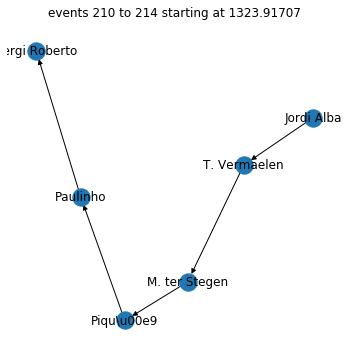

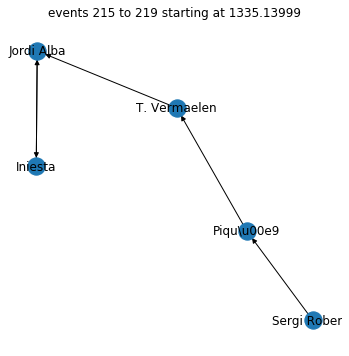

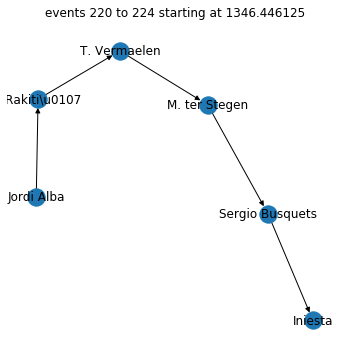

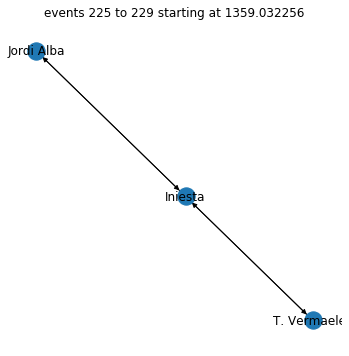

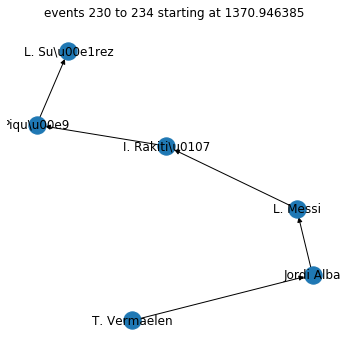

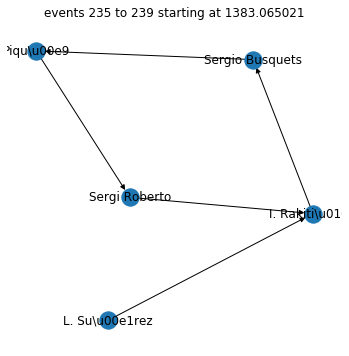

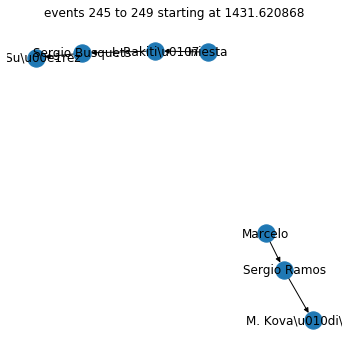

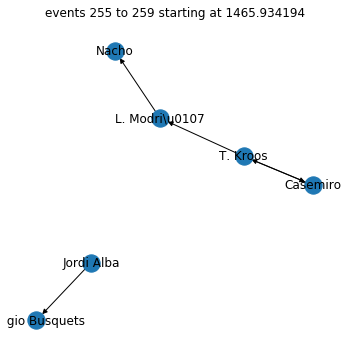

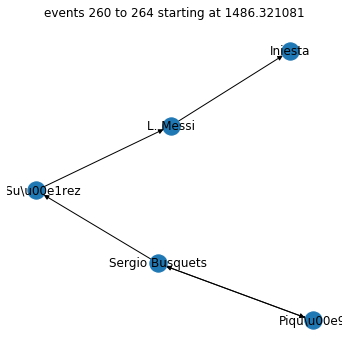

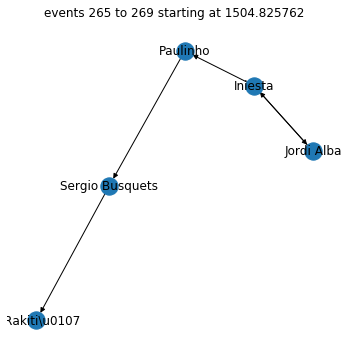

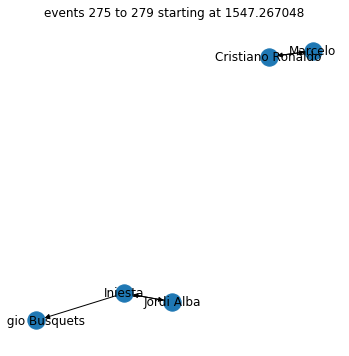

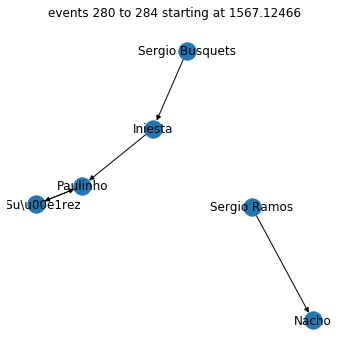

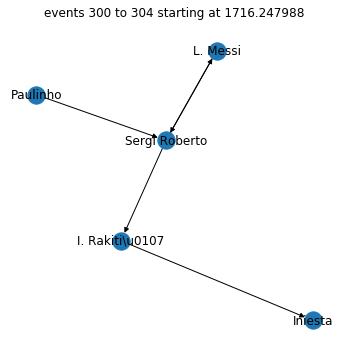

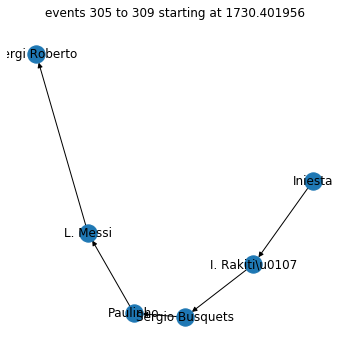

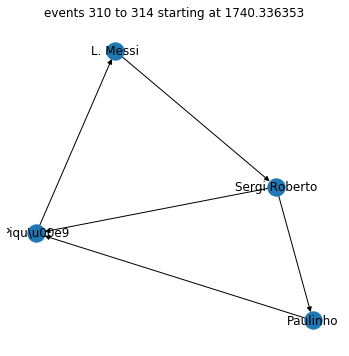

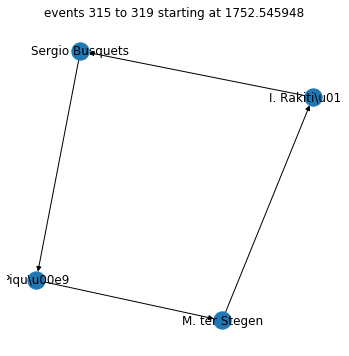

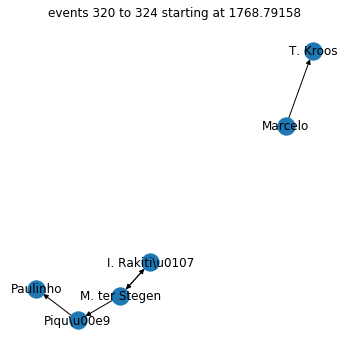

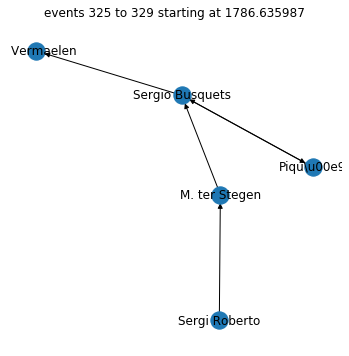

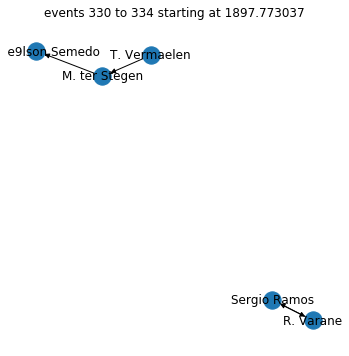

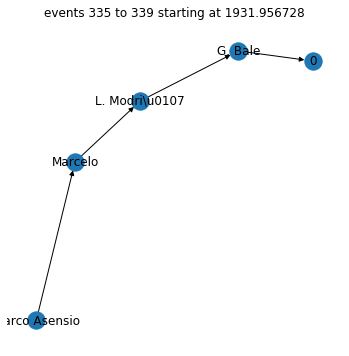

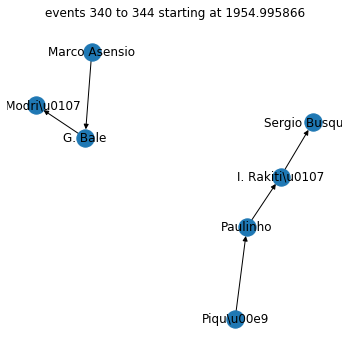

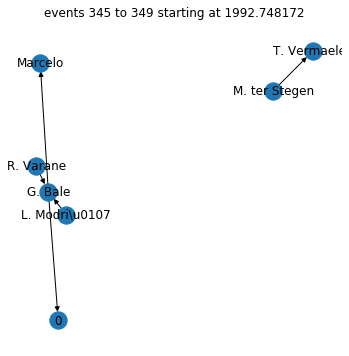

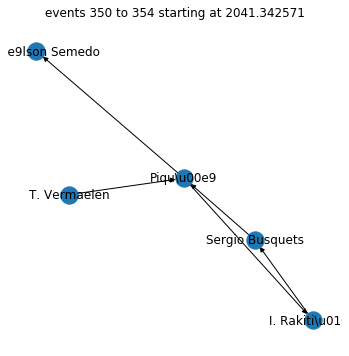

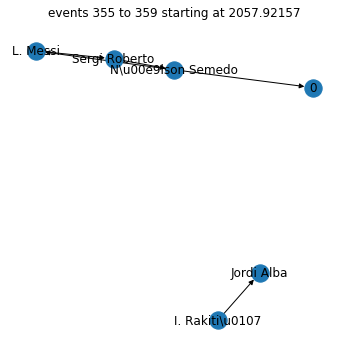

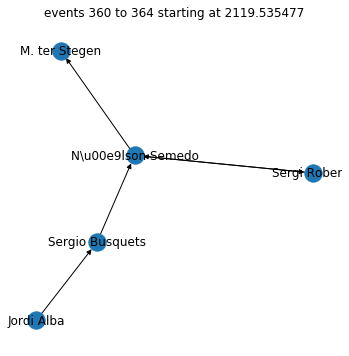

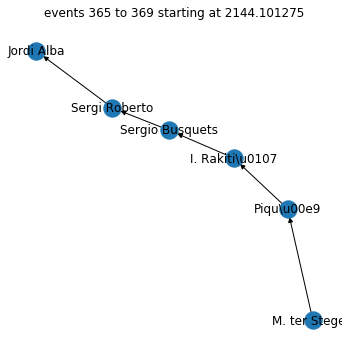

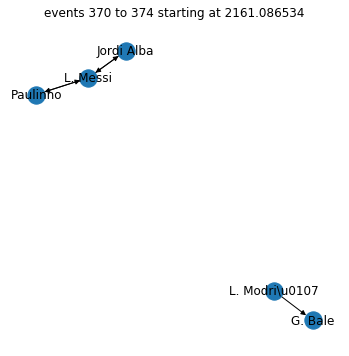

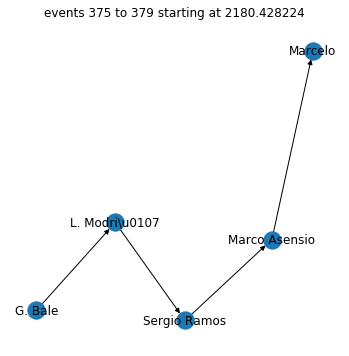

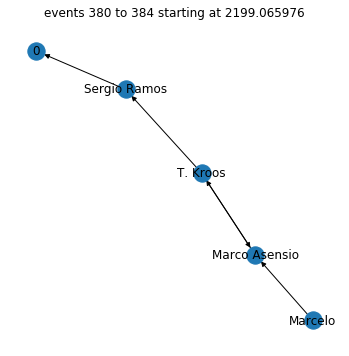

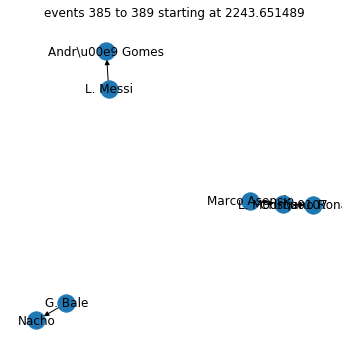

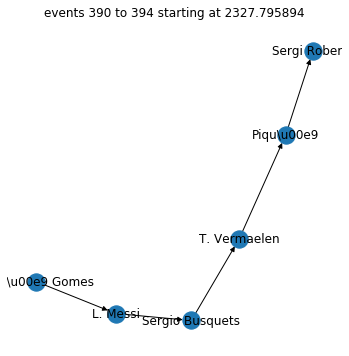

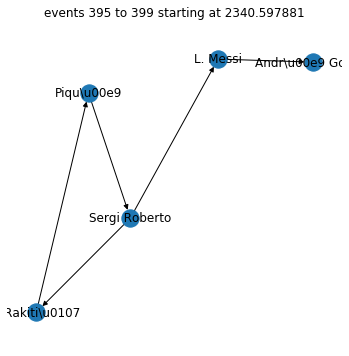

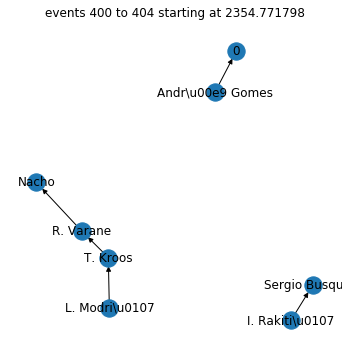

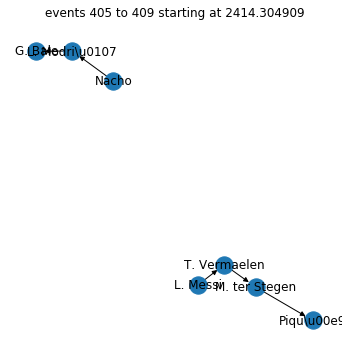

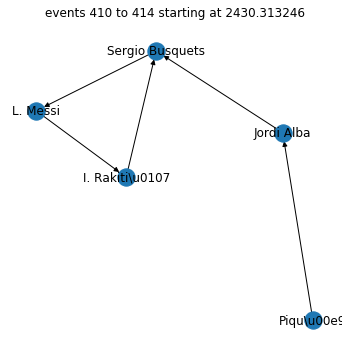

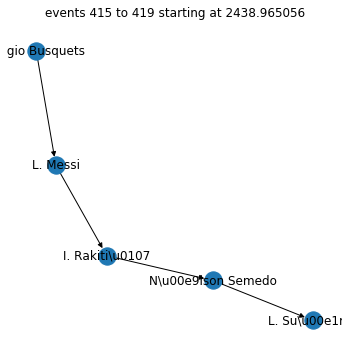

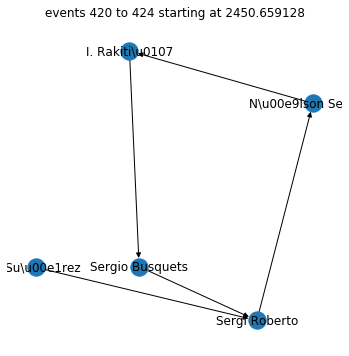

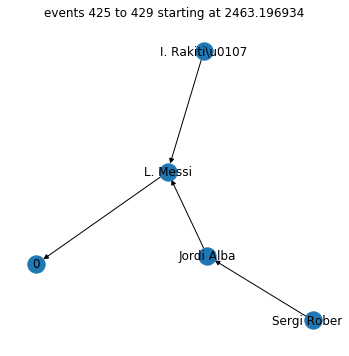

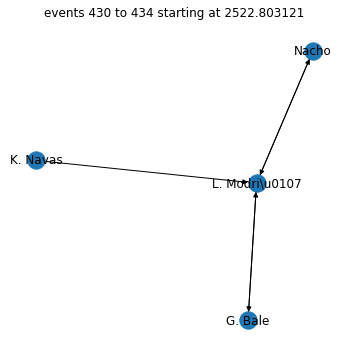

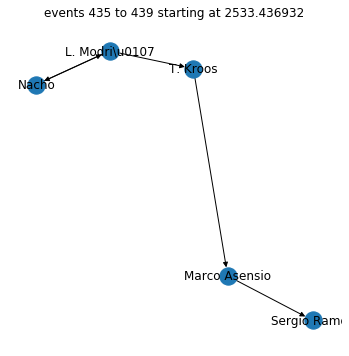

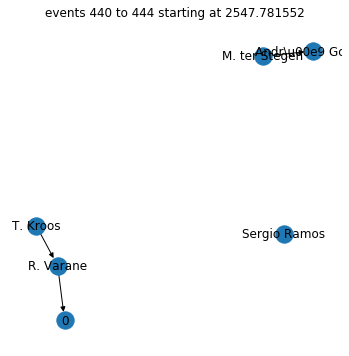

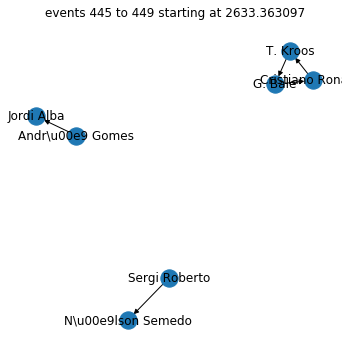

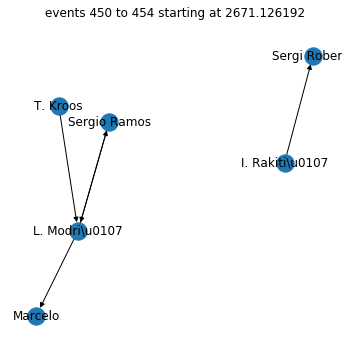

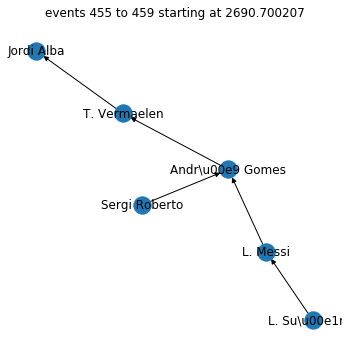

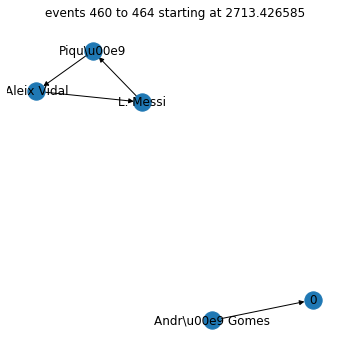

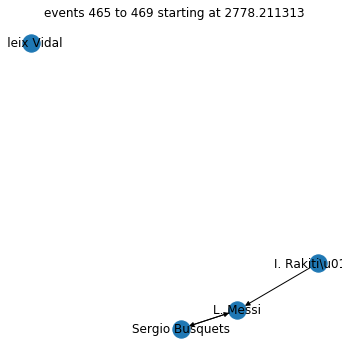

In [262]:
for i in range(0,len(fin),5):
    passes = passeslist(df.loc[fin[i]:fin[i+4]])
    G = weighted_passes(passes)
    plt.figure(figsize = (6,6))
    plt.title(f'events {i} to {i+4} starting at {time[i]}')
    nx.draw(G, with_labels = True)

In [189]:
passes = passeslist(df.head(1))

In [191]:
G = weighted_passes(passes)

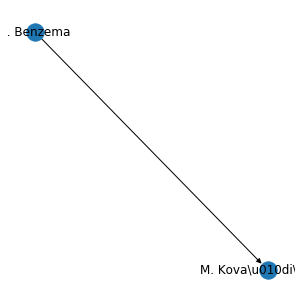

In [193]:
plt.figure(figsize = (4,4))
nx.draw(G, with_labels = True)

In [40]:
uniques = []
for i in list(df['eventId']):
    if i not in uniques:
        uniques.append(i)

In [28]:
def split_teams(df, homeID, awayID):
    df_home = df.loc[df['teamId'] == homeID]
    df_away = df.loc[df['teamId'] == awayID]
    return df_home, df_away

In [29]:
df_h, df_a = split_teams(game, 3799, 3772)

In [30]:
def passes_only(df):
    df = df.loc[df['eventName'] == 'Pass']
    return df

In [31]:
pass_h = passes_only(df_h)

In [32]:
pass_h.head()

eventId subEventName            tags  playerId  \
0         8  Simple pass  [{'id': 1801}]    253784   
1         8    High pass  [{'id': 1801}]     29474   
12        8    Hand pass  [{'id': 1801}]     26245   
13        8  Simple pass  [{'id': 1801}]     26086   
14        8  Simple pass  [{'id': 1801}]     29474   

                                   positions  matchId eventName  teamId  \
0   [{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]  2500686      Pass    3799   
1   [{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]  2500686      Pass    3799   
12  [{'y': 46, 'x': 13}, {'y': 86, 'x': 34}]  2500686      Pass    3799   
13  [{'y': 86, 'x': 34}, {'y': 39, 'x': 32}]  2500686      Pass    3799   
14  [{'y': 39, 'x': 32}, {'y': 78, 'x': 32}]  2500686      Pass    3799   

   matchPeriod   eventSec subEventId         id  
0           1H   1.935181         85  176505119  
1           1H   3.599295         83  176505121  
12          1H  19.984771         81  176505135  
13          1H  26.513924         85  176505137  
14          1H  30.569943         85  176505138

Need to understand the data better. Can I find out if a pass was completed, and then the player lost it in the dribble? Can I even abstract it to this level that I ignore so much information? Maybe compare with the footy data and try to spot the key differences. Actually - don't do passes only, keep the data and see if the pass was accurate- as then you can see who received it even if they lost the ball. Then create the next column and then reduce it to passes only.

The code has started to trend in the right direction but there's a lot I need to consider- I need there to be ways for the play to end which aren't a team intercepting the ball (ie a shot). I also need to consider some of the exceptions- for example what I do now takes out 'Acceleration' - but that means it shows as if they never received the ball if they didn't end up passing it. Maybe read more of Jordan's/Decroos GitHub to understand data better, or just keep playing with it and look at what all possible events are so that can make all necessary exceptions!

In [136]:
matches = pd.read_json('matches/matches_Spain.json')

In [145]:
sorted(matches['venue'].unique())

['Camp Nou',
 'Coliseum Alfonso P\\u00e9rez',
 'Estadi Municipal de Montilivi',
 'Estadio Benito Villamar\\u00edn',
 'Estadio Ciudad de Valencia',
 'Estadio La Rosaleda',
 'Estadio Municipal de Anoeta',
 'Estadio Municipal de Butarque',
 'Estadio Municipal de Ipur\\u00faa',
 'Estadio Municipal de Riazor',
 'Estadio Ram\\u00f3n S\\u00e1nchez Pizju\\u00e1n',
 'Estadio Santiago Bernab\\u00e9u',
 'Estadio Wanda Metropolitano',
 'Estadio de Bala\\u00eddos',
 'Estadio de Gran Canaria',
 'Estadio de Mendizorroza',
 'Estadio de Mestalla',
 'Estadio de la Cer\\u00e1mica',
 'RCDE Stadium',
 'San Mam\\u00e9s Barria']

In [149]:
mat = matches.loc[matches['venue'] == 'Estadio Santiago Bernab\\u00e9u']
mat = mat.loc[mat['gameweek'] == 17]
mat

status  roundId  gameweek  \
213  Played  4406122        17   

                                             teamsData  seasonId  \
213  {'675': {'scoreET': 0, 'coachId': 275283, 'sid...    181144   

                 dateutc  winner                           venue     wyId  \
213  2017-12-23 12:00:00     676  Estadio Santiago Bernab\u00e9u  2565711   

                              label                                   date  \
213  Real Madrid - Barcelona, 0 - 3  December 23, 2017 at 1:00:00 PM GMT+1   

                                              referees duration  competitionId  
213  [{'refereeId': 395085, 'role': 'referee'}, {'r...  Regular            795